In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

from pybaseball import statcast

# Make plots look nicer
sns.set(style="whitegrid", context="talk")

In [14]:
# Example: get Statcast data for one week in April 2024
df = statcast(start_dt="2024-04-01", end_dt="2024-04-07")
df.shape


This is a large query, it may take a moment to complete


  0%|                                                                                          | 0/7 [00:00<?, ?it/s]/Users/calebgoodman/Documents/coding/funProjects/bball/venv/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|███████████▋                                                                      | 1/7 [00:01<00:07,  1.19s/it]/Users/calebgoodman/Documents/coding/funProjects/bball/venv/lib/python3.13/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignor

(25979, 118)

In [15]:
df.head()


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2653,CU,2024-04-07,85.2,-2.31,6.16,"Johnson, Pierce",664983,572955,field_out,hit_into_play,...,2,3.78,-0.73,0.73,36.0,21.26133,-9.620944,34.858224,44.484484,39.961796
2691,CU,2024-04-07,86.0,-2.33,6.15,"Johnson, Pierce",664983,572955,NaN,called_strike,...,2,3.52,-0.78,0.78,41.6,<NA>,<NA>,<NA>,<NA>,<NA>
2813,CU,2024-04-07,85.8,-2.27,6.2,"Johnson, Pierce",553993,572955,field_out,hit_into_play,...,1,3.49,-0.91,-0.91,42.2,14.211988,7.795369,34.318302,45.151528,27.733033
2906,CU,2024-04-07,86.5,-2.3,6.24,"Johnson, Pierce",572233,572955,single,hit_into_play,...,1,3.39,-0.9,-0.9,38.3,4.061736,9.400294,24.872673,33.739691,28.735222
2952,CU,2024-04-07,86.1,-2.18,6.16,"Johnson, Pierce",572233,572955,NaN,ball,...,1,3.51,-1.14,-1.14,40.2,<NA>,<NA>,<NA>,<NA>,<NA>


In [16]:
# Keep only columns we care about for xwOBA modeling
cols = ["game_date", "player_name", "events", "launch_speed", 
        "launch_angle", "hit_location", "woba_value"]
df_small = df[cols]
df_small.head(10)


,game_date,player_name,events,launch_speed,launch_angle,hit_location,woba_value
2653,2024-04-07,"Johnson, Pierce",field_out,72.8,-19,3,0.0
2691,2024-04-07,"Johnson, Pierce",NaN,<NA>,<NA>,<NA>,<NA>
2813,2024-04-07,"Johnson, Pierce",field_out,85.3,12,4,0.0
2906,2024-04-07,"Johnson, Pierce",single,99.0,9,8,0.9
2952,2024-04-07,"Johnson, Pierce",NaN,<NA>,<NA>,<NA>,<NA>
3015,2024-04-07,"Johnson, Pierce",NaN,80.9,41,<NA>,<NA>
3141,2024-04-07,"Johnson, Pierce",NaN,<NA>,<NA>,<NA>,<NA>
3246,2024-04-07,"Johnson, Pierce",NaN,<NA>,<NA>,<NA>,<NA>
3395,2024-04-07,"Johnson, Pierce",field_out,95.5,37,8,0.0
3455,2024-04-07,"Johnson, Pierce",NaN,<NA>,<NA>,<NA>,<NA>


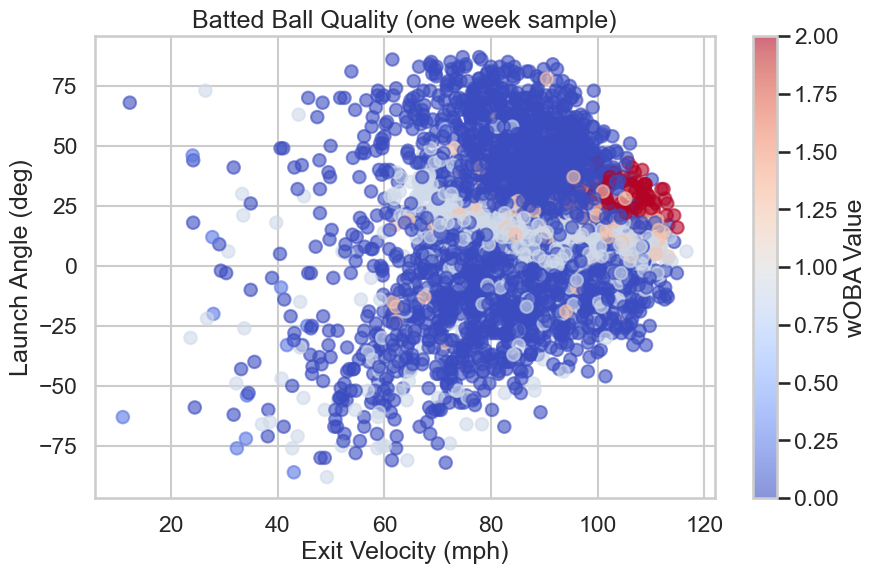

In [9]:
# Scatterplot of launch angle vs. exit velocity colored by woba_value
plt.figure(figsize=(10,6))
sc = plt.scatter(df_small["launch_speed"], df_small["launch_angle"], 
                 c=df_small["woba_value"], cmap="coolwarm", alpha=0.6)
plt.colorbar(sc, label="wOBA Value")
plt.xlabel("Exit Velocity (mph)")
plt.ylabel("Launch Angle (deg)")
plt.title("Batted Ball Quality (one week sample)")
plt.show()


Mean Squared Error: 0.2843011020197231
R² Score: 0.05984877098740893
Intercept: -0.524217983095306
Coefficients: {'launch_speed': np.float64(0.010115421624826853), 'launch_angle': np.float64(-0.0006758983224649186)}


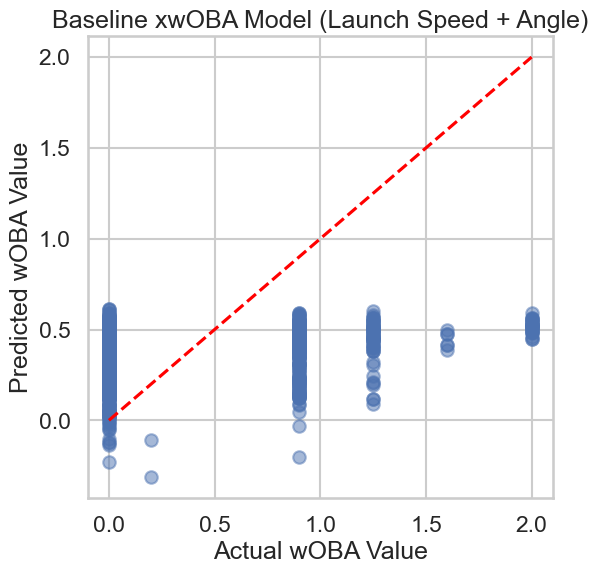

In [17]:
# data
df_model = df_small.dropna(subset=["launch_speed", "launch_angle", "woba_value"])

X = df_model[["launch_speed", "launch_angle"]]
y = df_model["woba_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# numbers
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)
print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(X.columns, model.coef_)))

# visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual wOBA Value")
plt.ylabel("Predicted wOBA Value")
plt.title("Baseline xwOBA Model (Launch Speed + Angle)")
plt.plot([0, 2], [0, 2], color="red", linestyle="--")
plt.show()